# Stack-Augmented Recurrent Neural Networks

In [1]:
# Import libraries and relevant dependencies
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import string
from torch.autograd import Variable

# Dyck library
from tasks.dyck_generator import DyckLanguage

# RNN Models
from models.rnn_models import VanillaRNN, SRNN_Softmax, SRNN_Softmax_Temperature, SRNN_GumbelSoftmax

# Set default tensor type "double"
torch.set_default_tensor_type('torch.DoubleTensor')

#### Fix the random seed:

In [2]:
randomseed_num = 23
print ('RANDOM SEED: {}'.format(randomseed_num))
random.seed (randomseed_num)
np.random.seed (randomseed_num)
torch.manual_seed(randomseed_num)

RANDOM SEED: 23


#### GPU/CPU Checkpoint

In [3]:
# GPU/CPU Check
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") ## GPU stuff
print (device)

cpu


## Dyck Languages

A probabilistic context-free grammar for $\mathcal{D}_n$ can be written as follows:

\begin{align*}
S \rightarrow \begin{cases} 
(_i\, S\, )_i & \text{with probability } \frac{p}{n} \\
S\,S & \text{with probability } q \\ 
\varepsilon & \text{with probability } 1 - (p+q) 
\end{cases}
\end{align*}
where $0 < p, q < 1$ and $p+q < 1$.

### Training and Test Corpora Generation

Training corpus window : [`MIN_SIZE`, `MAX_SIZE`]

Test corpus window: [`MAX_SIZE+2`, `2*MAX_SIZE`]

In [4]:
## Parameters of the Probabilistic Dyck Language 
NUM_PAR = 2
MIN_SIZE = 2
MAX_SIZE = 50
P_VAL = 0.5
Q_VAL = 0.25

# Number of samples in the training corpus
TRAINING_SIZE = 5000
# Number of samples in the test corpus
TEST_SIZE = 5000

# Create a Dyck language generator
Dyck = DyckLanguage (NUM_PAR, P_VAL, Q_VAL)
all_letters = word_set = Dyck.return_vocab ()
n_letters = vocab_size = len (word_set)

print('Loading data...')

training_input, training_output, st = Dyck.training_set_generator (TRAINING_SIZE, MIN_SIZE, MAX_SIZE)
test_input, test_output, st2 = Dyck.training_set_generator (TEST_SIZE, MAX_SIZE + 2, 2 * MAX_SIZE)

for i in range (1):
    print (training_input[i])
    print (training_output[i])
    print (Dyck.lineToTensor(training_input[i]))
    print (Dyck.lineToTensorSigmoid(training_output[i]))
    print (test_input[i])
    print (test_output[i])

Loading data...
500 samples generated.
1000 samples generated.
1500 samples generated.
2000 samples generated.
2500 samples generated.
3000 samples generated.
3500 samples generated.
4000 samples generated.
4500 samples generated.
5000 samples generated.
500 samples generated.
1000 samples generated.
1500 samples generated.
2000 samples generated.
2500 samples generated.
3000 samples generated.
3500 samples generated.
4000 samples generated.
4500 samples generated.
5000 samples generated.
[(([(([[([[()]]([[(())]([])]))]]))]))]
21121122122122112211122121211221121120
tensor([[[0., 0., 1., 0.]],

        [[1., 0., 0., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[1., 0., 0., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 1., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 1., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 1., 0., 0.]],

        [[0., 0., 0., 1.]],

        [[0., 0., 0., 

### Stack-RNN  Parameters

In [5]:
# Number of hidden units
n_hidden = 8
# Number of hidden layers
n_layers = 1
# Stack size
stack_size = 104
stack_dim = 1

# Parameters for the temperature-based methods
temp = 1.0
temp_min = 0.5
ANNEAL_RATE = .00001

In [6]:
## Stack-RNN with Softmax
model = SRNN_Softmax (n_hidden, vocab_size, vocab_size, n_layers, stack_size, stack_dim).to(device)
# Learning rate
learning_rate = .01
# Minimum Squared Error (MSE) loss
criterion = nn.MSELoss() 
# Adam optimizer (https://arxiv.org/abs/1412.6980)
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [7]:
print ('Model details:')
print (model)

Model details:
SRNN_Softmax(
  (rnn): RNN(4, 8)
  (W_y): Linear(in_features=8, out_features=4, bias=True)
  (W_n): Linear(in_features=8, out_features=1, bias=True)
  (W_a): Linear(in_features=8, out_features=2, bias=True)
  (W_sh): Linear(in_features=1, out_features=8, bias=True)
  (softmax): Softmax(dim=2)
  (sigmoid): Sigmoid()
)


In [8]:
# Number of epochs to train our model
epoch_num = 3
# Output threshold
epsilon = 0.5

### Training and Testing the Stack-RNN Model

In [9]:
def test_model (model, data_input, data_output):
    # Turn on the eval mode
    model.eval()
    # Total number of "correctly" predicted samples
    correct_num = 0
    with torch.no_grad():
        for i in range (len(data_output)):
            len_input = len (data_input[i])
            model.zero_grad ()
            # Initialize the hidden state
            hidden = model.init_hidden()
            # Initialize the stack
            stack = torch.zeros (stack_size, stack_dim).to(device)
            # Target values
            target = Dyck.lineToTensorSigmoid(data_output[i]).to(device) 
            # Output values
            output_vals = torch.zeros (target.shape)
            
            for j in range (len_input):
                output, hidden, stack = model (Dyck.lineToTensor(data_input[i][j]).to(device), hidden, stack)
                output_vals [j] = output

            # Binarize the entries based on the output threshold
            out_np = np.int_(output_vals.detach().numpy() >= epsilon)
            target_np = np.int_(target.detach().numpy())
            
            # (Double-)check whether the output values and the target values are the same
            if np.all(np.equal(out_np, target_np)) and (out_np.flatten() == target_np.flatten()).all():
                # If so, increase `correct_num` by one
                correct_num += 1
                
    return float(correct_num)/len(data_output) * 100, correct_num

In [10]:
def train (model, optimizer, criterion, epoch_num=5):
    # Turn on the train model for the model
    model.train()
    # Arrays for loss and "moving" accuracy per epoch
    loss_arr = []
    correct_arr = []
    for epoch in range(1, epoch_num + 1):
        print ('Epoch: {}'.format(epoch))
        
        # Total loss per epoch
        total_loss = 0
        # Total number of "correctly" predicted samples so far in the epoch
        counter = 0

        for i in range (TRAINING_SIZE):
            len_input = len (training_input[i])
            # Good-old zero grad
            model.zero_grad ()
            # Initialize the hidden state
            hidden = model.init_hidden()
            # Initialize the stack 
            stack = torch.zeros (stack_size, stack_dim).to(device)
            # Target values
            target = Dyck.lineToTensorSigmoid(training_output[i]).to(device) 
            # Output values
            output_vals = torch.zeros (target.shape)

            for j in range (len_input):
                output, hidden, stack = model (Dyck.lineToTensor(training_input[i][j]).to(device), hidden, stack)
                output_vals [j] = output
            
            # MSE (y, y_bar)
            loss = criterion (output_vals, target)
            # Add the current loss to the total loss
            total_loss += loss.item()
            # Backprop! 
            loss.backward ()
            optimizer.step ()
            
            # Print the performance of the model every 500 steps
            if i % 250 == 0:
                print ('Sample Number {}: '.format(i))
                print ('Input : {}'.format(training_input[i]))
                print ('Output: {}'.format(training_output[i]))
                print ('* Counter: {}'.format(counter))
                print ('* Avg Loss: {}'.format(total_loss/(i+1))) 

            # Binarize the entries based on the output threshold
            out_np = np.int_(output_vals.detach().numpy() >= epsilon)
            target_np = np.int_(target.detach().numpy())
                
            # "Moving" training accuracy
            if np.all(np.equal(out_np, target_np)) and (out_np.flatten() == target_np.flatten()).all():
                counter += 1
                
            # At the end of the epoch, append our total loss and "moving" accuracy
            if i == TRAINING_SIZE - 1:
                print ('Counter: {}'.format(float(counter)/TRAINING_SIZE))
                loss_arr.append (total_loss)
                correct_arr.append(counter) 

        if epoch % 1 == 0:
            print ('Training Accuracy %: ', correct_arr)
            print ('Loss: ', loss_arr)

#### Let there be light!

In [11]:
train (model, optim, criterion)

Epoch: 1
Sample Number 0: 
Input : [(([(([[([[()]]([[(())]([])]))]]))]))]
Output: 21121122122122112211122121211221121120
* Counter: 0
* Avg Loss: 0.2677200118981196
Sample Number 250: 
Input : [[([])[[[()]]][]]]
Output: 221212222122222220
* Counter: 4
* Avg Loss: 0.08202969477102737
Sample Number 500: 
Input : ([([[[]]])])[()(())]
Output: 12122222121021211120
* Counter: 13
* Avg Loss: 0.06508684667290639
Sample Number 750: 
Input : ([[[[]]]([[]([])])[()]])
Output: 122222221222121212212210
* Counter: 17
* Avg Loss: 0.057161322414884724
Sample Number 1000: 
Input : ((([([([[((([[[[]]]])))]])])])))
Output: 11121212211122222221112212121110
* Counter: 41
* Avg Loss: 0.051815942688128065
Sample Number 1250: 
Input : (())([])
Output: 11101210
* Counter: 80
* Avg Loss: 0.04557923457709883
Sample Number 1500: 
Input : ([[([([()(([]))][[]])])]])[(())]
Output: 12212121211211212221212210211120
* Counter: 211
* Avg Loss: 0.03983834912463715
Sample Number 1750: 
Input : [(([]))]([])[([[[]()[][][([])

Sample Number 4000: 
Input : ([[[[(()(()))](())]]])
Output: 1222211111112211122210
* Counter: 4000
* Avg Loss: 8.405212639650892e-07
Sample Number 4250: 
Input : ([]([([[[[()]]]])]()[(([([[]])]))()]))
Output: 12112122221222212111211212221211212110
* Counter: 4250
* Avg Loss: 8.062354531333981e-07
Sample Number 4500: 
Input : (((([[([(([([[[[[()]]]]()])]))])]]))))()[]
Output: 111122121121222221222221212112122111101020
* Counter: 4500
* Avg Loss: 7.733024911169704e-07
Sample Number 4750: 
Input : [[[([[[[[[[]]]([])]]]])]][([()])]]
Output: 2221222222222212122221222212121220
* Counter: 4750
* Avg Loss: 7.434378441085437e-07
Counter: 1.0
Training Accuracy %:  [3064, 4999, 5000]
Loss:  [71.62476816812956, 0.07101361427248555, 0.0035747676964660298]
Epoch: 4
Sample Number 0: 
Input : [(([(([[([[()]]([[(())]([])]))]]))]))]
Output: 21121122122122112211122121211221121120
* Counter: 0
* Avg Loss: 1.7450913012441883e-07
Sample Number 250: 
Input : [[([])[[[()]]][]]]
Output: 221212222122222220
* Co

### Evaluate the Performance of the Stack-RNN Model

In [12]:
# Training set accuracy 
correct_num = test_model (model, training_input, training_output)
print ('Training accuracy: {}.'.format(correct_num))

Training accuracy: (100.0, 5000).


In [13]:
# Test set accuracy 
correct_num = test_model (model, test_input, test_output)
print ('Test accuracy: {}.'.format(correct_num))

Test accuracy: (100.0, 5000).


### Save/Upload the Model Weights

In [14]:
# Save the model weights
torch.save(model.state_dict(), 'models/stack_rnn_model_weights.pth')

In [15]:
# # Load the model weights
# model.load_state_dict(torch.load('models/stack_rnn_model_weights.pth'))

## Visualize the Stack Elements

In [16]:
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot, plot
import plotly.graph_objs as go
import math

import seaborn as sns; sns.set()

import matplotlib
import matplotlib.pyplot as plt

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

### Get the Hidden State and Stack Configuration for a Given Input

In [17]:
def get_hidden_and_stack_info (model, input, output):
    # Turn on the evaluation mode for the model
    model.eval()
    # Hidden state values
    hidden_states = []
    # Stack configuration
    stack_config = []
    # Stack operation weights
    operation_weights = []
    # Most recently pushed element to the stack
    new_elt_inserted = []
    
    with torch.no_grad():
        len_input = len (input)
        model.zero_grad ()
        
        # Initialize the hidden state
        hidden = model.init_hidden()
        # Initalize the stack configuration
        stack = torch.zeros (stack_size, stack_dim).to(device)
        # Target values
        target = Dyck.lineToTensorSigmoid(output)
        # Output values
        output_vals = torch.zeros (target.shape).to(device)

        for j in range (len_input):
            # Feed the input to the model
            output, hidden, stack = model (Dyck.lineToTensor(input[j]).to(device), hidden, stack)
            # Hidden state values
            hidden_states.append (hidden.cpu().numpy())
            # Stack configuration 
            stack_config.append (stack.cpu().numpy())
            # Stack operation weights
            operation_weights.append (model.action_weights.cpu().numpy())
            # New element inserted to the stack
            new_elt_inserted.append (model.new_elt.cpu().numpy())
            # Output value
            output_vals [j] = output.view(-1)
        
        # Binarize the entries based on the output threshold
        out_np = np.int_(output_vals.cpu().detach().numpy() >= epsilon)
        target_np = np.int_(target.cpu().detach().numpy())
        
        # (Double-)check whether the output values and the target values are the same
        if np.all(np.equal(out_np, target_np)) and (out_np.flatten() == target_np.flatten()).all():
            print ('Correct!')
        else:
            print ('Incorrect')
            
    return hidden_states, stack_config, operation_weights, new_elt_inserted

In [18]:
input_seq = '([])[[[((([[(())]])))]]][()]'
output_seq =  Dyck.output_generator (input_seq)

In [19]:
hidden_states, stack_config, operation_weights, new_elt_inserted = get_hidden_and_stack_info (model, input_seq, output_seq)

Correct!


### Visualize the Stack Operation Weights at Each Timestep

In [20]:
def visualize_stack_operation_weights (operation_weights, input_seq, timestep=0):
    # Stack operation labels
    labels = ['PUSH', 'POP']
    stack_op_weights = np.squeeze(operation_weights)
    plt.figure(figsize=(16, 5))
    fig = sns.heatmap(stack_op_weights.T, cmap=sns.light_palette("#34495e"),xticklabels=input_seq, yticklabels=labels, vmin=0, vmax=1)
    fig.set_title('Strength of Stack Operations at Each Timestep', fontsize=17)
    cbar = fig.collections[0].colorbar
    cbar.set_ticks(np.linspace(0,1,6))
    plt.xlabel('Sequence', fontsize=16)
    plt.ylabel('Actions', fontsize=16)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=14)
    plt.show()
    # plt.savefig('stackrnn_weights', dpi=128, bbox_inches='tight')

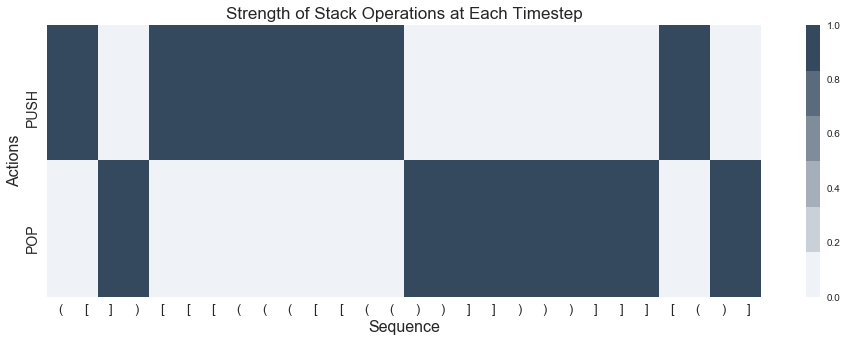

In [21]:
visualize_stack_operation_weights (operation_weights, input_seq)

### Visualize the Stack Configuration at Each Timestep

In [22]:
def visualize_stack_configuration (stack_config, input, dimension=0):
    stack_bound = 13 #len (input)
    print (np.array(stack_config).shape)
    print (stack_bound)
    stack_config = np.round(np.array(stack_config)[:, :stack_bound+1, dimension], decimals=3)
    location = np.arange (1, stack_bound+2)
    plt.figure(figsize=(18, 12))
    fig = sns.heatmap(stack_config.T, cmap='viridis', yticklabels = location, xticklabels=input, annot=True, cbar=False)
    fig.invert_yaxis()
    fig.set_title('Stack Entries at Each Timestep', fontsize=17)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Sequence', fontsize=16)
    plt.ylabel('Stack Location', fontsize=16)
    plt.show()

(28, 104, 1)
13


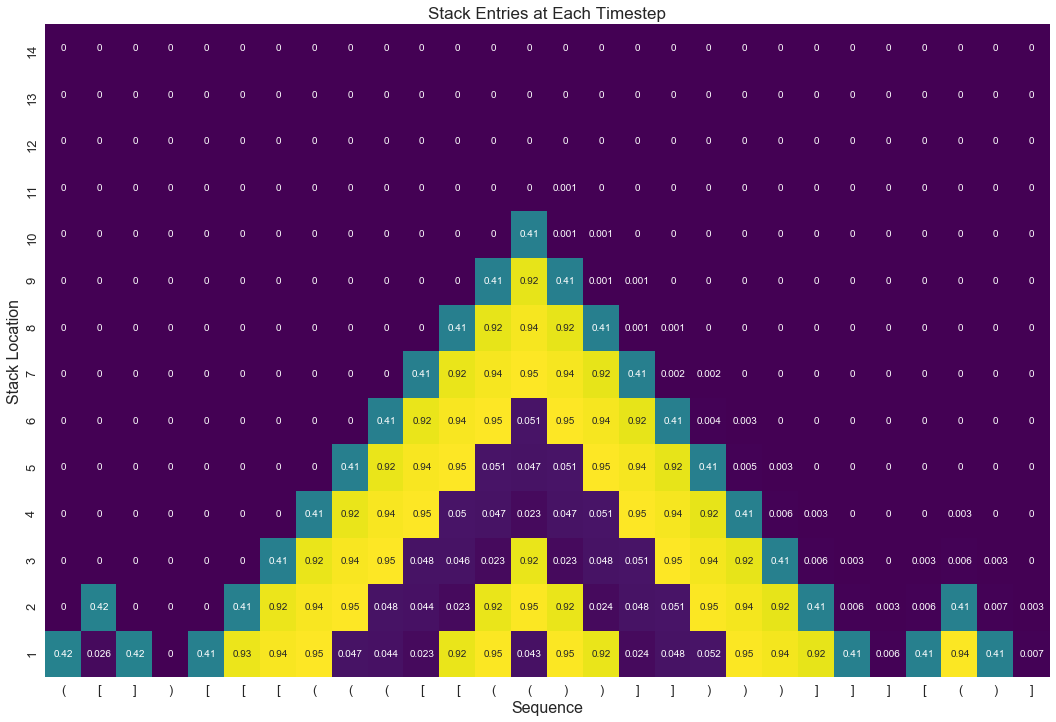

In [23]:
visualize_stack_configuration (stack_config, input_seq, 0)

### Visualize the Hidden State Values at Each Timestep

In [24]:
def visualize_hidden_states (hidden_states, input):
    plt.style.use('default')
    domain = list(range(len(input)))
    hidden_states = np.squeeze(hidden_states).T
    for i in range (int(n_hidden/2)):
        plt.figure()
        for j in range (2):
            plt.plot (domain, hidden_states[i*2+j], label='Unit {}'.format(i*2+j+1))
        plt.legend (loc='upper right')
        plt.xticks(domain, input_seq) 
        plt.title ('Analysis of the Hidden State Dynamics')
        plt.ylabel ('Activation Values')
        plt.ylim (-1.15, 1.15, 10)
        plt.show()

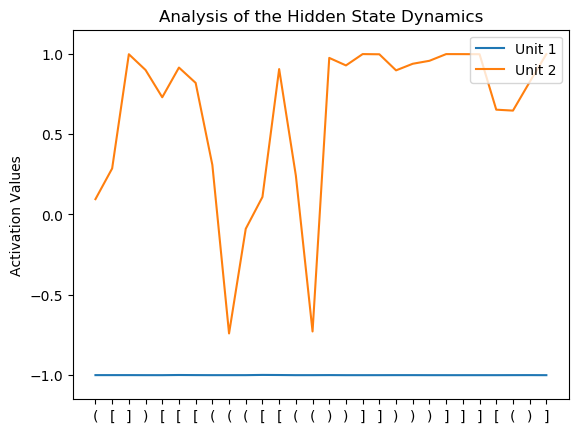

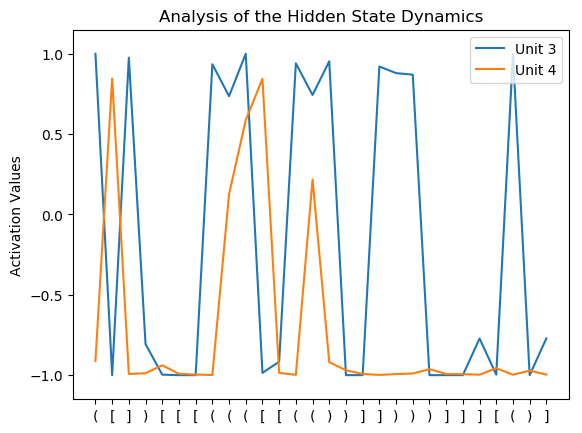

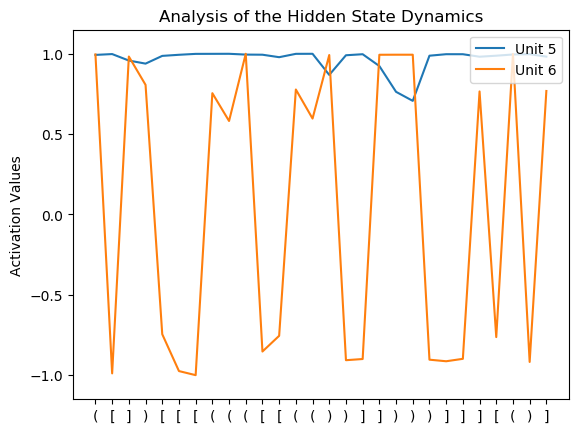

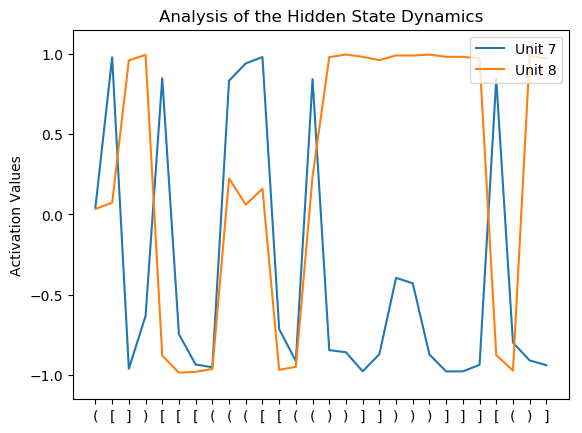

In [25]:
visualize_hidden_states (hidden_states, input_seq)

In [26]:
# Q.E.D.